# Open-Loop Simulation

In [28]:
import numpy as np
from control import acker
from DCmotor import dc_motor

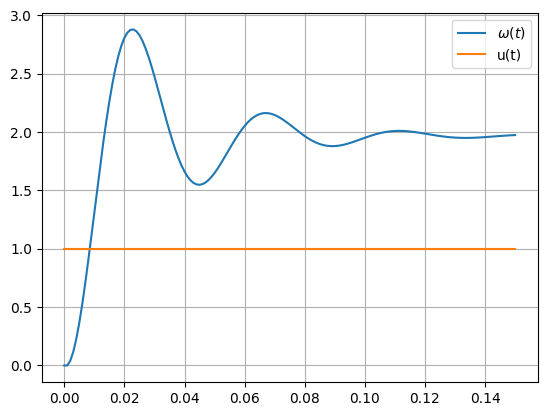

In [29]:
servo = dc_motor(0.5, 5.2e-4, 23.8e-3, 0.002, 2, 0.5)
servo.step(0.15)
servo.plot()

# Control synthesis

The state feedback $u=r-Kx$ can place the eigenvalues of (A - Bk) in any desired position. The following code computes the gain matrix $K$ such that the eigenvalues of (A - Bk) are placed in the desired position.

T_load:  0 DC error:  0.010019392372333513


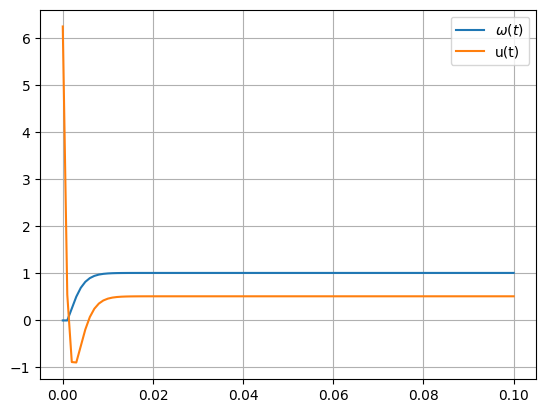

T_load:  100 DC error:  0.40848093083387194


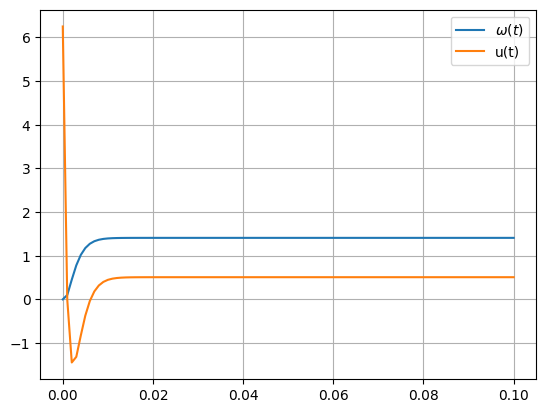

In [30]:
wd = 0.5/servo.sampling_time
K = acker(servo.A, servo.B, [-wd, -wd])
r = 1

def sim_static_gain(time, T_load):
    servo.sys_init()
    for i in range(int(0.1/servo.sampling_time)):
        x = np.array([[servo.simulation_data['Ia'][-1]], [servo.simulation_data['w'][-1]]])
        u = r/(1-0.84) - K.dot(x)
        servo.sys_dynamics(u[0][0], T_load)
    print('T_load: ', T_load, 'DC error: ', servo.simulation_data['w'][-1] - r)
    servo.plot()

sim_static_gain(0.2, 0)
sim_static_gain(0.2, 100)


## Internal Model
The eigenvalues of (A - Bk) are the poles of the closed-loop system, and they determine the transient response of the system. The closed-loop system is stable, but still has a DC error, this error can change due to change of load, environment, or aging. An integrative internal model will be added to the controller to eliminate the DC error.

The controller internal model loop can be defined by:
$$\dot{x}_c = A_c x_c + B_c r $$ 
$$u = K_c x_c - K x $$

The internal model of an integrator can be defined by:
$$A_c = 0$$
$$B_c = 1$$

T_load =  0 N.m DC error =  -5.02009545044757e-12


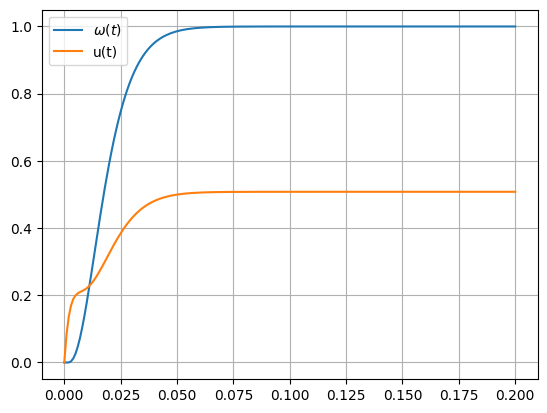

T_load =  100 N.m DC error =  1.4017675908917226e-12


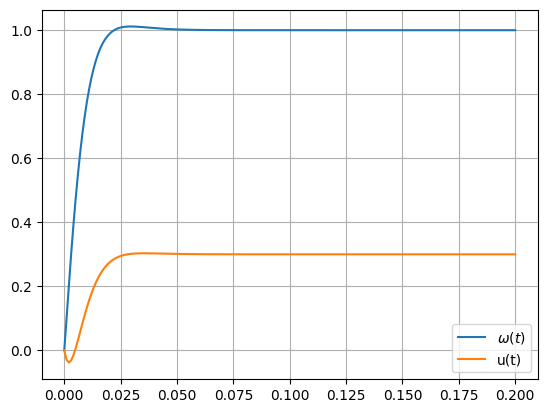

In [31]:
C = np.array([[0, 1]])
D = np.array([[0]])

Ac = [[0]]
Bc = 1
Aa = np.concatenate((servo.A, [[0],[0]]), axis=1) # Aa = [[A 0], -B_cC A_c]
Aa = np.concatenate((Aa, np.concatenate((C.dot(-Bc), Ac), axis=1)), axis=0)
Ba = np.concatenate((servo.B, D.dot(-Bc)), axis=0)

wd = 150
k = acker(Aa, Ba, [-wd, -wd, -wd])[0]
K = np.array([k[0:2]])
Kc = np.array([[k[2]]])

r = 1
def sim_internal_model(time, T_load):
    servo.sys_init()
    xc = 0
    for i in range(int(time/servo.sampling_time)):
        x = np.array([[servo.simulation_data['Ia'][-1]], [servo.simulation_data['w'][-1]]])
        u = Kc.dot(xc) - K.dot(x)
        servo.sys_dynamics(u[0][0], T_load)
        xc += Bc*(C.dot(x)[0][0] - r)*servo.sampling_time
    print('T_load = ', T_load, 'N.m', 'DC error = ', servo.simulation_data['w'][-1] - r)
    servo.plot()

sim_internal_model(0.2, 0)
sim_internal_model(0.2, 100)

